## *Настройка витрины данных на основе существующей схемы PostgreSQL*
### Витрина данных (Data Mart) создается для удобного анализа и агрегации данных. Мы будем использовать SQL-запросы для построения витрины на основе уже загруженных таблиц:

- orders (заказы)
- products_category (категории товаров)
- order_items (позиции заказов)
1. Определение структуры витрины
### Витрина должна объединять данные из всех трех таблиц и содержать:

- Информацию о заказах (дата покупки, дата доставки, ID клиента)
- Информацию о товарах (категория)
- Финансовые показатели (цена, стоимость доставки, суммарная выручка)
- Метрики по доставке (время доставки)
### Создадим витрину order_summary в PostgreSQL.



### Установка и подключение библиотек

In [10]:
%pip install pandas sqlalchemy psycopg2 matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

### Подключение к PostgreSQL

In [12]:
import pandas as pd
from sqlalchemy import create_engine

# Параметры подключения к базе данных
db_user = "myuser"
db_password = "mypassword"
db_host = "localhost"
db_port = "5432"
db_name = "mydatabase"

connection_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_string)

# Загрузка данных из CSV
try:
    products_category = pd.read_csv('products_category.csv')
    order_items = pd.read_csv('order_items.csv')
    orders = pd.read_csv('orders.csv')

    # Запись данных в PostgreSQL
    products_category.to_sql("products_category", engine, if_exists="replace", index=False, method='multi')
    order_items.to_sql("order_items", engine, if_exists="replace", index=False, method='multi')
    orders.to_sql("orders", engine, if_exists="replace", index=False, method='multi')

    print("Импорт завершён!")
except Exception as e:
    print(f"Произошла ошибка: {e}")

Произошла ошибка: [Errno 2] No such file or directory: 'products_category.csv'


### Создание витрины данных

In [13]:
from sqlalchemy import text

query = text("""
CREATE MATERIALIZED VIEW IF NOT EXISTS order_summary AS
SELECT 
    o.order_id,
    o.customer_id,
    o.purchase_timestamp,
    o.delivered_customer_date,
    p.product_category_name,
    oi.price,
    oi.sales_value,
    oi.freight_value,
    oi.delivery_time,
    (oi.sales_value + oi.freight_value) AS total_revenue
FROM order_items oi
JOIN orders o ON oi.order_id = o.order_id
JOIN products_category p ON oi.product_id = p.product_id;
""")

with engine.connect() as conn:
    conn.execute(query)
    conn.commit()  # Не забудь зафиксировать изменения!
    print("Витрина order_summary создана!")

Витрина order_summary создана!


### Обновление витрины (при необходимости)

In [14]:
from sqlalchemy import text

with engine.connect() as conn:
    conn.execute(text("REFRESH MATERIALIZED VIEW order_summary;"))
    conn.commit()  # Фиксируем изменения
    print("Витрина обновлена!")

Витрина обновлена!


### Загрузка данных из витрины

In [15]:
df = pd.read_sql("SELECT * FROM order_summary", con=engine)
df.head()

,order_id,customer_id,purchase_timestamp,delivered_customer_date,product_category_name,price,sales_value,freight_value,delivery_time,total_revenue
0,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,2017-05-12,pet_shop,239.90,239.90,19.93,16.0,259.83
1,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,2017-03-01,garden_tools,199.90,199.90,18.14,25.0,218.04
2,00048cc3ae777c65dbb7d2a0634bc1ea,85c835d128beae5b4ce8602c491bf385,2017-05-15,2017-05-22,housewares,21.90,21.90,12.69,7.0,34.59
3,000c3e6612759851cc3cbb4b83257986,f5f088001070650f9e9a8cd773621f35,2017-08-12,2017-08-19,sports_leisure,99.00,99.00,13.71,7.0,112.71
4,000e906b789b55f64edcb1f84030f90d,3588484a539617d91500764822230fb6,2017-11-21,2017-12-09,telephony,21.99,21.99,11.85,18.0,33.84


### Визуализация данных

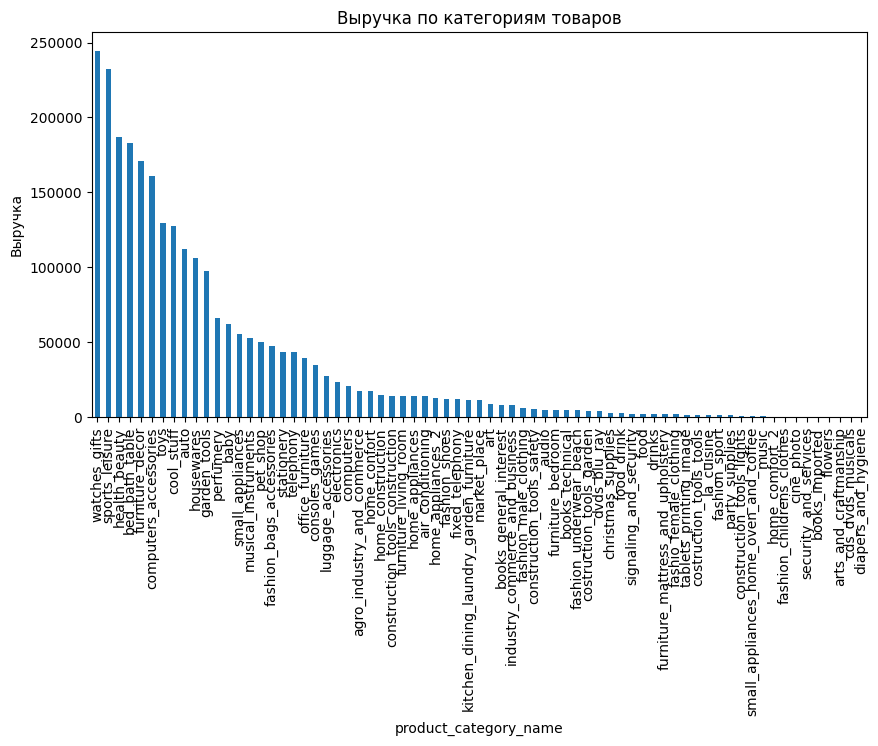

In [16]:
category_sales = df.groupby('product_category_name')['total_revenue'].sum()
category_sales.sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title="Выручка по категориям товаров")
plt.ylabel("Выручка")
plt.show()